
런타임 유형변경 >> GPU

In [1]:
# 구글 드라이브와 Colab 연동
from google.colab import drive
drive.mount('/content/drive') # 출력되는 URL에 접속하여 verification code 복사 및 붙여넣기

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 작업할 공간 설정
import os
os.getcwd() # 현재 path 확인

'/content'

In [3]:
os.chdir('/content/drive/My Drive/PyConKorea2019-Tutorials/LRP') # 작업할 path를 google drive로 이동
os.getcwd()

'/content/drive/My Drive/PyConKorea2019-Tutorials/LRP'

### 1. 전처리 (base code :  https://cyc1am3n.github.io/2018/11/10/classifying_korean_movie_review.html)

In [4]:
#For more detail preprocessing script, please refer 'PyConKorea2019-Tutorials/LRP/preprocessing.ipynb'
import pickle
import numpy as np
#load 
with open("nsmc_train_x.txt", "rb") as fp:
    X_train = pickle.load(fp)
with open("nsmc_test_x.txt", "rb") as fp:
    X_test = pickle.load(fp)
with open("nsmc_train_y.txt", "rb") as fp:
    train_y = pickle.load(fp)
with open("nsmc_test_y.txt", "rb") as fp:
    test_y = pickle.load(fp)
with open("nsmc_selected_words.txt", "rb") as fp:
    selected_words_10000 = pickle.load(fp) 


### 2. LSTM 훈련

In [5]:
import numpy as np
import keras

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.models import Model, load_model

import matplotlib.pyplot as plt
from IPython.display import display, HTML

from numpy import newaxis as na

import tensorflow
print(f"tensorflow version: {tensorflow.__version__}")
print(f"keras version: {keras.__version__}")

tensorflow version: 2.8.2
keras version: 2.8.0


In [6]:
max_features = 10000
maxlen = 100
batch_size = 1024

In [7]:
# One-hot encoding the output >> 
num_classes = 2
y_train = keras.utils.np_utils.to_categorical(train_y, num_classes)
y_test = keras.utils.np_utils.to_categorical(test_y, num_classes)

In [8]:
print('훈련 데이터: {}'.format(len(X_train)))
print('테스트 데이터: {}'.format(len(X_test)))
print('카테고리: {}'.format(num_classes))

훈련 데이터: 150000
테스트 데이터: 50000
카테고리: 2


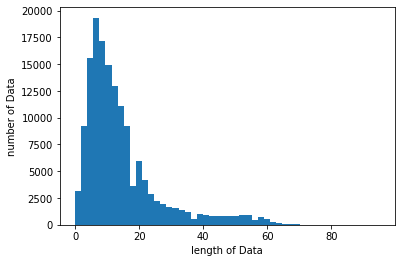

In [9]:
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

In [10]:
maxlen = 30
x_train = sequence.pad_sequences(X_train, maxlen)
x_test = sequence.pad_sequences(X_test, maxlen)

In [11]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=3)

Train...
Epoch 1/3
147/147 [==============================] - 31s 171ms/step - loss: 0.4448 - accuracy: 0.7902
Epoch 2/3
147/147 [==============================] - 20s 136ms/step - loss: 0.3252 - accuracy: 0.8590
Epoch 3/3
147/147 [==============================] - 21s 144ms/step - loss: 0.3073 - accuracy: 0.8659


In [12]:
# from keras.models import load_model
# model = load_model('lstm.h5')

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 1,411,842
Trainable params: 1,411,842
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.evaluate(x_test, y_test)

1563/1563 [==============================] - 18s 11ms/step - loss: 0.3458 - accuracy: 0.8450


[0.3457610011100769, 0.844980001449585]

### 3. LRP & Visualization (base code : https://github.com/ArrasL/LRP_for_LSTM)

In [15]:
def html_heatmap (words, scores, cmap_name="bwr"):
    """
    Return word-level heatmap in HTML format,
    with words being the list of words (as string),
    scores the corresponding list of word-level relevance values,
    and cmap_name the name of the matplotlib diverging colormap.
    """
    
    colormap  = plt.get_cmap(cmap_name)
     
    #assert len(words)==len(scores)
    max_s     = max(scores)
    min_s     = min(scores)
    
    output_text = ""
    
    for idx, w in enumerate(words):
        score       = rescale_score_by_abs(scores[idx], max_s, min_s)
        output_text = output_text + span_word(w, score, colormap) + " "
    
    return output_text + "\n"

def rescale_score_by_abs (score, max_score, min_score):
    """
    Normalize the relevance value (=score), accordingly to the extremal relevance values (max_score and min_score), 
    for visualization with a diverging colormap.
    i.e. rescale positive relevance to the range [0.5, 1.0], and negative relevance to the range [0.0, 0.5],
    using the highest absolute relevance for linear interpolation.
    """
    
    # CASE 1: positive AND negative scores occur --------------------
    if max_score>0 and min_score<0:
    
        if max_score >= abs(min_score):   # deepest color is positive
            if score>=0:
                return 0.5 + 0.5*(score/max_score)
            else:
                return 0.5 - 0.5*(abs(score)/max_score)

        else:                             # deepest color is negative
            if score>=0:
                return 0.5 + 0.5*(score/abs(min_score))
            else:
                return 0.5 - 0.5*(score/min_score)   
    
    # CASE 2: ONLY positive scores occur -----------------------------       
    elif max_score>0 and min_score>=0: 
        if max_score == min_score:
            return 1.0
        else:
            return 0.5 + 0.5*(score/max_score)
    
    # CASE 3: ONLY negative scores occur -----------------------------
    elif max_score<=0 and min_score<0: 
        if max_score == min_score:
            return 0.0
        else:
            return 0.5 - 0.5*(score/min_score)
          

def getRGB (c_tuple):
    return "#%02x%02x%02x"%(int(c_tuple[0]*255), int(c_tuple[1]*255), int(c_tuple[2]*255))

     
def span_word (word, score, colormap):
    return "<span style=\"background-color:"+getRGB(colormap(score))+"\">"+word+"</span>"

In [16]:
names = [weight.name for layer in model.layers for weight in layer.weights]
print(names)

['embedding/embeddings:0', 'lstm/lstm_cell/kernel:0', 'lstm/lstm_cell/recurrent_kernel:0', 'lstm/lstm_cell/bias:0', 'dense/kernel:0', 'dense/bias:0']


In [17]:
class LRP4LSTM(object):
    def __init__(self, model):
        self.model = model
        
        names = [weight.name for layer in model.layers for weight in layer.weights]
        weights = model.get_weights()

        # suppress scientific notation
        np.set_printoptions(suppress=True)
        for name, weight in zip(names, weights):
            if name == 'lstm/lstm_cell/kernel:0':
                kernel_0 = weight
            if name == 'lstm/lstm_cell/recurrent_kernel:0':
                recurrent_kernel_0 = weight
            if name == 'lstm/lstm_cell/bias:0':
                bias_0 = weight
            elif name == 'dense/kernel:0':
                output = weight


        print("kernel_0", kernel_0.shape)
        print("recurrent_kernel_0", recurrent_kernel_0.shape)
        print("bias_0", bias_0.shape)
        print("output", output.shape)

        # self.Wxh_Left (240, 60)
        # self.Whh_Left (240, 60)
        # self.bxh_Left (240,)
        # self.Why_Left (5, 60)

        self.Wxh = kernel_0.T  # shape 4d*e
        self.Whh = recurrent_kernel_0.T  # shape 4d
        self.bxh = bias_0.T  # shape 4d 
        self.Why = output.T
        
    def lrp_linear(self, hin, w, b, hout, Rout, bias_nb_units, eps, bias_factor=1.0, debug=False):
        """
        LRP for a linear layer with input dim D and output dim M.
        Args:
        - hin:            forward pass input, of shape (D,)
        - w:              connection weights, of shape (D, M)
        - b:              biases, of shape (M,)
        - hout:           forward pass output, of shape (M,) (unequal to np.dot(w.T,hin)+b if more than one incoming layer!)
        - Rout:           relevance at layer output, of shape (M,)
        - bias_nb_units:  total number of connected lower-layer units (onto which the bias/stabilizer contribution is redistributed for sanity check)
        - eps:            stabilizer (small positive number)
        - bias_factor:    set to 1.0 to check global relevance conservation, otherwise use 0.0 to ignore bias/stabilizer redistribution (recommended)
        Returns:
        - Rin:            relevance at layer input, of shape (D,)
        """
        sign_out = np.where(hout[na,:]>=0, 1., -1.) # shape (1, M)

        numer    = (w * hin[:,na]) + ( bias_factor * (b[na,:]*1. + eps*sign_out*1.) / bias_nb_units ) # shape (D, M)
        # Note: here we multiply the bias_factor with both the bias b and the stabilizer eps since in fact
        # using the term (b[na,:]*1. + eps*sign_out*1.) / bias_nb_units in the numerator is only useful for sanity check
        # (in the initial paper version we were using (bias_factor*b[na,:]*1. + eps*sign_out*1.) / bias_nb_units instead)

        denom    = hout[na,:] + (eps*sign_out*1.)   # shape (1, M)

        message  = (numer/denom) * Rout[na,:]       # shape (D, M)

        Rin      = message.sum(axis=1)              # shape (D,)

        if debug:
            print("local diff: ", Rout.sum() - Rin.sum())
        # Note: 
        # - local  layer   relevance conservation if bias_factor==1.0 and bias_nb_units==D (i.e. when only one incoming layer)
        # - global network relevance conservation if bias_factor==1.0 and bias_nb_units set accordingly to the total number of lower-layer connections 
        # -> can be used for sanity check

        return Rin
        
    def get_layer_output(self, layer_name, data):
        # https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer
        intermediate_layer_model = keras.Model(inputs=self.model.input,
                                         outputs=self.model.get_layer(layer_name).output)
        return intermediate_layer_model.predict(data)  
    
    def run(self, target_data, target_class):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))
        
        #원본 소스에서 E embedding은 전체에 대한 단어 사전이고, x는 embedding된 인풋이다.  
        # w_indices [109, 11995, 25, 18263, 25, 973, 3138, 6389, 372]

        x = self.get_layer_output('embedding', target_data)
        e = x.shape[1]

       ################# forword
        T = target_data.shape[0]
        d = int(512/4)  # hidden units
        C = self.Why.shape[0] # number of classes

        idx    = np.hstack((np.arange(0,d), np.arange(2*d,4*d))).astype(int) # indices of gates i,f,o together
        idx_i, idx_f, idx_c, idx_o = np.arange(0,d), np.arange(d,2*d), np.arange(2*d,3*d), np.arange(3*d,4*d) # indices of gates i,g,f,o separately

        # 최종적으로 구하려는 값은 c에 저장될 값과 h으로 지워질 값
        h  = np.zeros((T,d))
        c  = np.zeros((T,d))

        gates_pre = np.zeros((T, 4*d))  # gates pre-activation
        gates     = np.zeros((T, 4*d))  # gates activation

        for t in range(T):

            gates_pre[t]    = np.dot(self.Wxh, x[t]) + np.dot(self.Whh, h[t-1]) + self.bxh

            gates[t,idx]    = sigmoid(gates_pre[t,idx])
            gates[t,idx_c]  = np.tanh(gates_pre[t,idx_c]) 

            c[t]            = gates[t,idx_f]*c[t-1] + gates[t,idx_i]*gates[t,idx_c]
            h[t]            = gates[t,idx_o]*np.tanh(c[t])

        score = np.dot(self.Why, h[t])    

        ################# backwork
        dx     = np.zeros(x.shape)

        dh          = np.zeros((T, d))
        dc          = np.zeros((T, d))
        dgates_pre  = np.zeros((T, 4*d))  # gates pre-activation
        dgates      = np.zeros((T, 4*d))  # gates activation

        ds               = np.zeros((C))
        ds[target_class] = 1.0
        dy               = ds.copy()

        #맨처음을 0으로 시작하지 않게 위한조치
        dh[T-1]     = np.dot(self.Why.T, dy)

        for t in reversed(range(T)): 
            dgates[t,idx_o]    = dh[t] * np.tanh(c[t])  # do[t]
            dc[t]             += dh[t] * gates[t,idx_o] * (1.-(np.tanh(c[t]))**2) # dc[t]
            dgates[t,idx_f]    = dc[t] * c[t-1]         # df[t]
            dc[t-1]            = dc[t] * gates[t,idx_f] # dc[t-1]
            dgates[t,idx_i]    = dc[t] * gates[t,idx_c] # di[t]
            dgates[t,idx_c]    = dc[t] * gates[t,idx_i] # dg[t]
            dgates_pre[t,idx]  = dgates[t,idx] * gates[t,idx] * (1.0 - gates[t,idx]) # d ifo pre[t]
            dgates_pre[t,idx_c]= dgates[t,idx_c] *  (1.-(gates[t,idx_c])**2) # d c pre[t]
            dh[t-1]            = np.dot(self.Whh.T, dgates_pre[t])
            dx[t]              = np.dot(self.Wxh.T, dgates_pre[t])

        ################# LRP
        eps=0.001 
        bias_factor=1.0
        Rx  = np.zeros(x.shape)
        Rh  = np.zeros((T+1, d))
        Rc  = np.zeros((T+1, d))
        Rg  = np.zeros((T,   d)) # gate g only

        Rout_mask            = np.zeros((C))
        Rout_mask[target_class] = 1.0  

        # format reminder: lrp_linear(hin, w, b, hout, Rout, bias_nb_units, eps, bias_factor)
        Rh[T-1]  = self.lrp_linear(h[T-1], self.Why.T, np.zeros((C)), score, score*Rout_mask, d, eps, bias_factor, debug=False)  

        for t in reversed(range(T)):
            Rc[t]   += Rh[t]
            Rc[t-1]  = self.lrp_linear(gates[t,idx_f]*c[t-1], np.identity(d), np.zeros((d)), c[t], Rc[t], d, eps, bias_factor, debug=False)
            Rg[t]    = self.lrp_linear(gates[t,idx_i]*gates[t,idx_c], np.identity(d), np.zeros((d)), c[t], Rc[t], d, eps, bias_factor, debug=False)
            Rx[t]    = self.lrp_linear(x[t], self.Wxh[idx_c].T, self.bxh[idx_c], gates_pre[t,idx_c], Rg[t], d+e, eps, bias_factor, debug=False)
            Rh[t-1]  = self.lrp_linear(h[t-1], self.Whh[idx_c].T, self.bxh[idx_c], gates_pre[t,idx_c], Rg[t], d+e, eps, bias_factor, debug=False)    

        return score, x, dx, Rx, Rh[-1].sum()

In [18]:
lrp = LRP4LSTM(model)

kernel_0 (128, 512)
recurrent_kernel_0 (128, 512)
bias_0 (512,)
output (128, 2)


In [19]:
def index_to_word(list):
    _ = []
    for x in list :
        _.append(selected_words_10000[x].split('/')[0])
    return _
  
def int_to_str(target_class):
    if target_class == 0 :
        return "부정"
    else :
        return "긍정"

In [20]:
predictions = model.predict(x_test)

In [21]:
positive_list = []
negative_list = []

for i in range(len(y_test)):
    if np.argmax(predictions[i]) == 1:
        positive_list.append(i)
    else :
        negative_list.append(i)

In [22]:
print("각 단어가 긍정이라고 예측하는데 영향을 미치는 정도" )
for index, i in enumerate(positive_list):
    
    target_full_data = x_test[i]
    target_data = target_full_data[target_full_data != 0]
    target_class = np.argmax(y_test[i])

    score, x, Gx, Rx, R_rest = lrp.run(target_data, target_class)

    R_words_SA       = (np.linalg.norm(Gx, ord=2, axis=0))**2   # compute word-level Sensitivity Analysis relevances
    R_words          = np.sum(Rx, axis=1)                       # compute word-level LRP relevances
    
    words = index_to_word(target_data) 

    if len(words) > 0 :
        print(" 예측 레이블:", int_to_str(np.argmax(predictions[i])), "| 실제 레이블 : ", int_to_str(target_class))

        print("        SA heatmap:")
        display(HTML(html_heatmap(words, R_words_SA)))
        
        print("        LRP heatmap:")
        display(HTML(html_heatmap(words, R_words)))

        print("-----------------------------------------------------------")

    if index == 20: # 20roaks 출력
      break

각 단어가 긍정이라고 예측하는데 영향을 미치는 정도
 예측 레이블: 긍정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 긍정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------


 예측 레이블: 긍정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------


 예측 레이블: 긍정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------


 예측 레이블: 긍정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------


 예측 레이블: 긍정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 긍정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------


 예측 레이블: 긍정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------


 예측 레이블: 긍정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------


 예측 레이블: 긍정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------


 예측 레이블: 긍정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------


 예측 레이블: 긍정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------


 예측 레이블: 긍정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------


 예측 레이블: 긍정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 긍정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------


 예측 레이블: 긍정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 긍정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 긍정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 긍정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------


 예측 레이블: 긍정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------


 예측 레이블: 긍정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------


In [23]:
print("각 단어가 부정이라고 예측하는데 영향을 미치는 정도" )
for index, i in enumerate(negative_list):
    
    target_full_data = x_test[i]
    target_data = target_full_data[target_full_data != 0]
    target_class = np.argmax(y_test[i])

    score, x, Gx, Rx, R_rest = lrp.run(target_data, target_class)

    R_words_SA       = (np.linalg.norm(Gx, ord=2, axis=0))**2   # compute word-level Sensitivity Analysis relevances
    R_words          = np.sum(Rx, axis=1)                       # compute word-level LRP relevances
    
    words = index_to_word(target_data) 

    if len(words) > 0 :
        print(" 예측 레이블:", int_to_str(np.argmax(predictions[i])), "| 실제 레이블 : ", int_to_str(target_class))

        print("        SA heatmap:")
        display(HTML(html_heatmap(words, R_words_SA)))
        
        print("        LRP heatmap:")
        display(HTML(html_heatmap(words, R_words)))

        print("-----------------------------------------------------------")

    if index == 20: # 20roaks 출력
      break

각 단어가 부정이라고 예측하는데 영향을 미치는 정도


 예측 레이블: 부정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------


 예측 레이블: 부정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------


 예측 레이블: 부정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------


 예측 레이블: 부정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------


 예측 레이블: 부정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 부정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------


 예측 레이블: 부정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------


 예측 레이블: 부정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------


 예측 레이블: 부정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------


 예측 레이블: 부정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------


 예측 레이블: 부정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------


 예측 레이블: 부정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 부정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 부정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------


 예측 레이블: 부정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------


 예측 레이블: 부정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------


 예측 레이블: 부정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------


 예측 레이블: 부정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------


 예측 레이블: 부정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------


 예측 레이블: 부정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------


 예측 레이블: 부정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
